Flags:
	batch_size: 25000
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 100
	grayscale_model: False
	hidden_dim: 256
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 10
	p: 0.1111111111111111
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	plot: True
	plot_fig5_irm_paper: False
	print_eval_intervals: True
	rex: True
	save_numpy_log: False
	shift: shift_spurious_x
	steps: 501
	test_env__color_noise: 0.9
	test_prob_class_0: 0.5
	train_env_1__color_noise: 0.2
	train_env_2__color_noise: 0.1
	train_set_size: 50000
	use_wandb: False
	wandb_project: cs_hparam_tuning_2
	wandb_tag: irm_hparams__stable_x_shift
Restart 0


100%|██████████| 9912422/9912422 [00:00<00:00, 84188285.41it/s]


Extracting /root/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104247585.05it/s]

Extracting /root/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26226261.55it/s]

Extracting /root/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21897159.50it/s]


Extracting /root/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/mnist/MNIST/raw

step            train nll       train acc       rex penalty     irmv1 penalty   test acc     
0               0.68437         0.56672         9.93191e-07     5.27968e-05     0.45690      
100             0.35375         0.85284         0.01569         0.00114         0.14340      
200             0.41608         0.81024         1.14115e-07     0.00516         0.34140      
300             0.41474         0.81068         3.27418e-09     0.00513         0.33280      
400             0.41398         0.81118         3.26055e-09     0.00512         0.32900      
500             0.41346         0.81132         3.23677e-09     0.00515         0.32780      
highest test acc this run: 0.4569
Final train acc (mean/std across restarts so far):
0.81131995 0.0
Final test acc (mean/std across restarts so far):
0.3278 0.0
Highest test acc (mean/std across restarts so far):
0.4569 0.0
Restart 1
step 

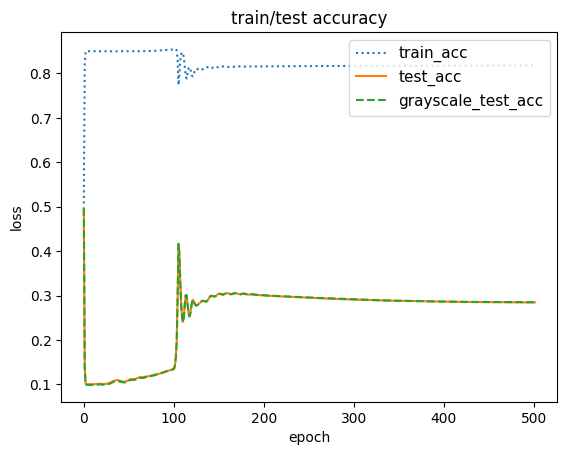

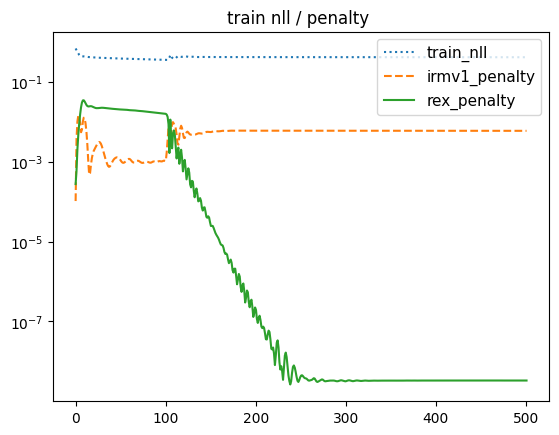

In [ ]:
import argparse
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch import nn, optim, autograd

import os
os.environ["WANDB_SILENT"] = "True"

#!pip install wandb

def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='Colored MNIST')
parser.add_argument('--hidden_dim', type=int, default=256)
parser.add_argument('--l2_regularizer_weight', type=float,default=0.001)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--n_restarts', type=int, default=10)
parser.add_argument('--penalty_anneal_iters', type=int, default=100)
parser.add_argument('--penalty_weight', type=float, default=10000.0)  # Setting both anneal iterations and penalty weight to 0 is equivalen to performing ERM.
parser.add_argument('--steps', type=int, default=501)
parser.add_argument('--grayscale_model', type=str2bool, default=False)
parser.add_argument('--batch_size', type=int, default=25000)
parser.add_argument('--train_set_size', type=int, default=50000)
parser.add_argument('--eval_interval', type=int, default=100)
parser.add_argument('--print_eval_intervals', type=str2bool, default=True)

parser.add_argument('--train_env_1__color_noise', type=float, default=0.2)
parser.add_argument('--train_env_2__color_noise', type=float, default=0.1)
parser.add_argument('--test_env__color_noise', type=float, default=0.9)

parser.add_argument('--erm_amount', type=float, default=1.0)

parser.add_argument('--early_loss_mean', type=str2bool, default=True)

parser.add_argument('--rex', type=str2bool, default=True)   # Setting this to False is equivalent to performing IRMv1.
parser.add_argument('--mse', type=str2bool, default=True)

parser.add_argument('--plot', type=str2bool, default=True)
parser.add_argument('--save_numpy_log', type=str2bool, default=False)

parser.add_argument('--p', type=float, default=1.0)
# Note: p controls the intensity of covariate shift, where p=1 means no covariate shift and p=0 means maximum covariate shift.
# The environment-varying covariate shift probability are set to be p_1=p/(1+p) in the first training environment and p_2=1/(1+p) in the second.

parser.add_argument('--test_prob_class_0', type=float, default=.5)

parser.add_argument('--plot_fig5_irm_paper', type=str2bool, default=False)

parser.add_argument('--wandb_tag', type=str, default="irm_hparams__stable_x_shift")
parser.add_argument('--wandb_project', type=str, default="cs_hparam_tuning_2")

parser.add_argument('--shift', type=str, default="shift_spurious_x")

parser.add_argument('--use_wandb', type=str2bool, default=False)

#flags = parser.parse_args()
flags, unknown = parser.parse_known_args()

if flags.use_wandb:
  import wandb

print('Flags:')
for k,v in sorted(vars(flags).items()):
  print("\t{}: {}".format(k, v))

num_batches = (flags.train_set_size // 2) // flags.batch_size

# TODO: logging
all_train_nlls = -1*np.ones((flags.n_restarts, flags.steps))
all_train_accs = -1*np.ones((flags.n_restarts, flags.steps))
all_irmv1_penalties = -1*np.ones((flags.n_restarts, flags.steps))
all_rex_penalties = -1*np.ones((flags.n_restarts, flags.steps))
all_test_accs = -1*np.ones((flags.n_restarts, flags.steps))
all_grayscale_test_accs = -1*np.ones((flags.n_restarts, flags.steps))

all_test_accs_less_than_train_accs = -1*np.ones((flags.n_restarts, flags.steps))

final_train_accs = []
final_test_accs = []
final_allowed_test_accs = []
highest_test_accs = []
max__min_of_train_acc_and_test_accs = []
min_of_final_train_acc_and_final_test_accs = []
for restart in range(flags.n_restarts):
  print("Restart", restart)

  highest_test_acc = 0.0
  max__min_of_train_acc_and_test_acc = 0.0

  # Load MNIST, make train/val splits, and shuffle train set examples

  mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
  mnist_train = (mnist.data[:50000], mnist.targets[:50000])
  mnist_val = (mnist.data[50000:], mnist.targets[50000:])

  rng_state = np.random.get_state()
  np.random.shuffle(mnist_train[0].numpy())
  np.random.set_state(rng_state)
  np.random.shuffle(mnist_train[1].numpy())

  # Build environments

  def make_environment(images, labels, e, p, grayscale_dup=False):
    def torch_bernoulli(p, size):
      return (torch.rand(size) < p).float()
    def torch_xor(a, b):
      return (a-b).abs() # Assumes both inputs are either 0 or 1
    # 2x subsample for computational convenience
    images = images.reshape((-1, 28, 28))[:, ::2, ::2]

    # Assign a binary label based on the digit; flip label with probability 0.25
    labels = (labels < 5).float()

    labels = torch_xor(labels, torch_bernoulli(.25, len(labels)))
    # Assign a color based on the label; flip the color with probability e
    colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
    # Apply the color to the image by zeroing out the other color channel

    colors_0s = (colors==0.0).nonzero()
    colors_1s = (colors==1.0).nonzero()

    colors_branch0 = torch_bernoulli(p, len(colors_0s))
    colors_branch1 = torch_bernoulli(1-p, len(colors_1s))

    all_colors0 = torch.scatter(torch.zeros_like(colors), 0, colors_0s.squeeze(1), colors_branch0)
    all_colors1 = torch.scatter(torch.zeros_like(colors), 0, colors_0s.squeeze(1), 1-colors_branch0)

    all_colors2 = torch.scatter(torch.zeros_like(colors), 0, colors_1s.squeeze(1), colors_branch1)
    all_colors3 = torch.scatter(torch.zeros_like(colors), 0, colors_1s.squeeze(1), 1-colors_branch1)

    id_0 = torch.stack([images, images], dim=1)
    id_1 = torch.stack([images, images], dim=1)
    id_2 = torch.stack([images, images], dim=1)
    id_3 = torch.stack([images, images], dim=1)

    id_0[torch.tensor(range(len(id_0))), (all_colors0).long(), :, :] *= 0
    id_1[torch.tensor(range(len(id_1))), (all_colors1).long(), :, :] *= 0
    id_2[torch.tensor(range(len(id_2))), (all_colors2).long(), :, :] *= 0
    id_3[torch.tensor(range(len(id_3))), (all_colors3).long(), :, :] *= 0

    images = torch.stack([id_0[:, 0], id_1[:, 0], id_2[:, 0], id_3[:, 0]], dim=1)

    del id_0, id_1, id_2, id_3

    if use_cuda:
      return {
        'images': (images.float() / 255.).cuda(),
        'labels': labels[:, None].cuda()
      }
    else:
      return {
        'images': (images.float() / 255.),
        'labels': labels[:, None]
      }

  p1 = flags.p / (1.0 + flags.p)
  p2 = 1.0 / (1.0 + flags.p) # this is equivalent to 1-p1

  envs = [
    make_environment(mnist_train[0][::2], mnist_train[1][::2], flags.train_env_1__color_noise, p1),
    make_environment(mnist_train[0][1::2], mnist_train[1][1::2], flags.train_env_2__color_noise, p2),
    make_environment(mnist_val[0], mnist_val[1], flags.test_env__color_noise, flags.test_prob_class_0),
    make_environment(mnist_val[0], mnist_val[1], flags.test_env__color_noise, flags.test_prob_class_0, grayscale_dup=True)
  ]

  # Define and instantiate the model

  class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      if flags.grayscale_model:
        lin1 = nn.Linear(14 * 14, flags.hidden_dim)
      else:
        lin1 = nn.Linear(4 * 14 * 14, flags.hidden_dim)
      lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
      lin3 = nn.Linear(flags.hidden_dim, 1)
      for lin in [lin1, lin2, lin3]:
        nn.init.xavier_uniform_(lin.weight)
        nn.init.zeros_(lin.bias)
      self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
    def forward(self, input):
      if flags.grayscale_model:
        out = input.view(input.shape[0], 4, 14 * 14).sum(dim=1)
      else:
        out = input.view(input.shape[0], 4 * 14 * 14)
      out = self._main(out)
      return out

  if use_cuda:
    mlp = MLP().cuda()
  else:
    mlp = MLP()

  # Define loss function helpers

  def mean_nll(logits, y):
    return nn.functional.binary_cross_entropy_with_logits(logits, y)

  def mean_accuracy(logits, y):
    preds = (logits > 0.).float()
    return ((preds - y).abs() < 1e-2).float().mean()

  def penalty(logits, y):
    if use_cuda:
      scale = torch.tensor(1.).cuda().requires_grad_()
    else:
      scale = torch.tensor(1.).requires_grad_()
    loss = mean_nll(logits * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)

  # Train loop

  def pretty_print(*values):
    col_width = 13
    def format_val(v):
      if not isinstance(v, str):
        v = np.array2string(v, precision=5, floatmode='fixed')
      return v.ljust(col_width)
    str_values = [format_val(v) for v in values]
    print("   ".join(str_values))

  optimizer = optim.Adam(mlp.parameters(), lr=flags.lr)

  pretty_print('step', 'train nll', 'train acc', 'rex penalty', 'irmv1 penalty', 'test acc')

  if flags.use_wandb:
    wandb.init(project=flags.wandb_project, reinit=True, tags=[flags.wandb_tag])
    wandb.config.update(flags)

  i = 0
  for step in range(flags.steps):
    n = i % num_batches
    for edx, env in enumerate(envs):
      if edx != len(envs) - 2:
        env['logits'] = mlp(env['images'][n*flags.batch_size:(n+1)*flags.batch_size])
        env['nll'] = mean_nll(env['logits'], env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
        env['acc'] = mean_accuracy(env['logits'], env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
        env['penalty'] = penalty(env['logits'], env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
      else:
        env['logits'] = mlp(env['images'])
        env['nll'] = mean_nll(env['logits'], env['labels'])
        env['acc'] = mean_accuracy(env['logits'], env['labels'])
        env['penalty'] = penalty(env['logits'], env['labels'])
    i+=1

    train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
    train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
    irmv1_penalty = torch.stack([envs[0]['penalty'], envs[1]['penalty']]).mean()

    if use_cuda:
      weight_norm = torch.tensor(0.).cuda()
    else:
      weight_norm = torch.tensor(0.)
    for w in mlp.parameters():
      weight_norm += w.norm().pow(2)

    loss1 = envs[0]['nll']
    loss2 = envs[1]['nll']

    if flags.early_loss_mean:
      loss1 = loss1.mean()
      loss2 = loss2.mean()

    loss = 0.0
    loss += flags.erm_amount * (loss1 + loss2)

    loss += flags.l2_regularizer_weight * weight_norm

    penalty_weight = (flags.penalty_weight
      if step >= flags.penalty_anneal_iters else 1.0)

    if flags.mse:
      rex_penalty = (loss1.mean() - loss2.mean()) ** 2
    else:
      rex_penalty = (loss1.mean() - loss2.mean()).abs()

    if flags.rex:
      loss += penalty_weight * rex_penalty
    else:
      loss += penalty_weight * irmv1_penalty

    if penalty_weight > 1.0:
      # Rescale the entire loss to keep gradients in a reasonable range
      loss /= penalty_weight

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_acc = envs[2]['acc']
    grayscale_test_acc = envs[3]['acc']

    if step % flags.eval_interval == 0:
      train_acc_scalar = train_acc.detach().cpu().numpy()
      test_acc_scalar = test_acc.detach().cpu().numpy()
      if flags.print_eval_intervals:
        pretty_print(
          np.int32(step),
          train_nll.detach().cpu().numpy(),
          train_acc.detach().cpu().numpy(),
          rex_penalty.detach().cpu().numpy(),
          irmv1_penalty.detach().cpu().numpy(),
          test_acc.detach().cpu().numpy()
        )
    min_both = min(train_acc.detach().cpu().numpy(), test_acc.detach().cpu().numpy())
    if (min_both > highest_test_acc):
      max__min_of_train_acc_and_test_acc = min_both
    if (train_acc_scalar >= test_acc_scalar) and (test_acc_scalar > highest_test_acc):
      highest_test_acc = test_acc_scalar

    if flags.plot or flags.save_numpy_log:
      all_train_nlls[restart, step] = train_nll.detach().cpu().numpy()
      all_train_accs[restart, step] = train_acc.detach().cpu().numpy()
      all_rex_penalties[restart, step] = rex_penalty.detach().cpu().numpy()
      all_irmv1_penalties[restart, step] = irmv1_penalty.detach().cpu().numpy()
      all_test_accs[restart, step] = test_acc.detach().cpu().numpy()
      all_grayscale_test_accs[restart, step] = grayscale_test_acc.detach().cpu().numpy()

    log_dict = {}
    log_dict.update({'min_of_train_acc_and_test_acc': min(train_acc.detach().cpu().numpy(), test_acc.detach().cpu().numpy()).item(),
                     'test_acc': test_acc.detach().cpu().numpy().item(),
                     'train_acc': train_acc.detach().cpu().numpy().item()
                    })

    if flags.use_wandb:
      wandb.log(log_dict)

  h_i = np.linspace(-5,5,101)
  if flags.plot_fig5_irm_paper:
    print(step)
    h_d = [{str('%.1f' % _): [] for _ in h_i} for _ in range(len(envs))]

    for i in range(len(envs)):
      xx = envs[i]['logits'][:,0].data.numpy()
      ll = envs[i]['labels'][:,0].data.numpy()

      for _xx, _ll in zip(xx, ll):
        if (_xx > -5.0) and (_xx < 5.0):
          r_xx = float('%.1f' % round(_xx, 1))
          h_d[i][str(0.0 if r_xx == -0.0 else r_xx)].append(_ll)

      from copy import deepcopy
      for k, v in deepcopy(h_d[i]).items():
        if v == []:
          del h_d[i][k]

    import matplotlib.pyplot as plt
    plt.plot([float(_) for _ in h_d[0].keys()], [sum(_)/len(_) for _ in h_d[0].values()], color='tab:blue', marker='.', linestyle='')
    plt.plot([float(_) for _ in h_d[1].keys()], [sum(_)/len(_) for _ in h_d[1].values()], color='tab:orange', marker='.', linestyle='')
    plt.plot([float(_) for _ in h_d[2].keys()], [sum(_)/len(_) for _ in h_d[2].values()], color='tab:green', marker='.', linestyle='')
    plt.axis([-5, 5, 0, 1])
    plt.show()

  print('highest test acc this run:', highest_test_acc)

  final_train_accs.append(train_acc.detach().cpu().numpy())
  final_test_accs.append(test_acc.detach().cpu().numpy())
  if test_acc < train_acc:
    final_allowed_test_accs.append(test_acc.detach().cpu().numpy())
  else:
    final_allowed_test_accs.append((test_acc.detach().cpu().numpy() * 0.0) - 1000.0)
  highest_test_accs.append(highest_test_acc)
  max__min_of_train_acc_and_test_accs.append(max__min_of_train_acc_and_test_acc)
  min_of_final_train_acc_and_final_test_accs.append(min(train_acc.detach().cpu().numpy(), test_acc.detach().cpu().numpy()))

  print('Final train acc (mean/std across restarts so far):')
  print(np.mean(final_train_accs), np.std(final_train_accs))
  print('Final test acc (mean/std across restarts so far):')
  print(np.mean(final_test_accs), np.std(final_test_accs))
  print('Highest test acc (mean/std across restarts so far):')
  print(np.mean(highest_test_accs), np.std(highest_test_accs))

log_dict = {}
log_dict.update({"mean__max__min_of_train_acc_and_test_acc": np.mean(max__min_of_train_acc_and_test_accs).item(),
                "std__max__min_of_train_acc_and_test_acc": np.std(max__min_of_train_acc_and_test_accs).item(),
                "mean__final__min_of_train_acc_and_test_acc": np.mean(min_of_final_train_acc_and_final_test_accs).item(),
                "std__final__min_of_train_acc_and_test_acc": np.std(min_of_final_train_acc_and_final_test_accs).item(),

                "mean__max__allowed_test_acc": np.mean(highest_test_accs).item(),
                "std__max__allowed_test_acc": np.std(highest_test_accs).item(),
                "mean__final__allowed_test_acc": np.mean(final_allowed_test_accs).item(),
                "std__final__allowed_test_acc": np.std(final_allowed_test_accs).item(),

                "mean__final__test_acc": np.mean(final_test_accs).item(),
                "std__final__test_acc": np.std(final_test_accs).item(),

                "mean__final__train_acc": np.mean(final_train_accs).item(),
                "std__final__train_acc": np.std(final_train_accs).item(),
          })

if flags.use_wandb:
  wandb.log(log_dict)
  wandb.join()

if flags.plot:
  plot_x = np.linspace(0, flags.steps, flags.steps)
  from pylab import *

  figure()
  xlabel('epoch')
  ylabel('loss')
  title('train/test accuracy')
  plot(plot_x, all_train_accs.mean(0), ls="dotted", label='train_acc')
  plot(plot_x, all_test_accs.mean(0), label='test_acc')
  plot(plot_x, all_grayscale_test_accs.mean(0), ls="--", label='grayscale_test_acc')
  legend(prop={'size': 11}, loc="upper right")
  savefig('train_acc__test_acc.pdf')

  figure()
  title('train nll / penalty ')
  plot(plot_x, all_train_nlls.mean(0), ls="dotted", label='train_nll')
  plot(plot_x, all_irmv1_penalties.mean(0), ls="--", label='irmv1_penalty')
  plot(plot_x, all_rex_penalties.mean(0), label='rex_penalty')
  yscale('log')
  legend(prop={'size': 11}, loc="upper right")
  savefig('train_nll__penalty.pdf')

if flags.save_numpy_log:
  import os
  directory = "np_arrays_paper"
  if not os.path.exists(directory):
    os.makedirs(directory)

  outfile = "all_train_nlls"
  np.save(directory + "/" + outfile, all_train_nlls)

  outfile = "all_irmv1_penalties"
  np.save(directory + "/" + outfile, all_irmv1_penalties)

  outfile = "all_rex_penalties"
  np.save(directory + "/" + outfile, all_rex_penalties)

  outfile = "all_train_accs"
  np.save(directory + "/" + outfile, all_train_accs)

  outfile = "all_test_accs"
  np.save(directory + "/" + outfile, all_test_accs)

  outfile = "all_grayscale_test_accs"
  np.save(directory + "/" + outfile, all_grayscale_test_accs)
